# 理論

回顧在KNN時提及「樹」的長相：

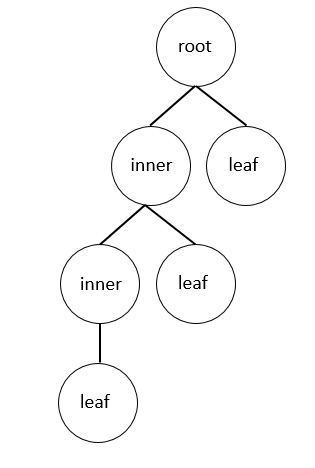

在決策樹當中一樣以這樣的資料型態儲存分類之結果。<br>
不同的地方在於 KNN是**非監督式學習**，而決策樹是**監督式學習**。<br>
而這個差別之處在演算法當中就是：

* KNN在擴張枝葉的時候不會考慮怎樣分能夠讓**葉節點**裡的資料最純(i.e.沒有太類別混雜在一起) <br>
* 而決策樹則會考量**在每一次的分枝當中，能讓每個節點裡的資料都盡量最純**的方式擴展枝葉。

對應到演算法方式則為：決策樹會以greedy algorithm(貪婪式演算法)，在每一步都搜尋最佳解才進到下一步。<br>
然而因為無法窮舉所有情況，所以每次分枝的時候都只會考量一部份的可能分枝。

* 好的情況下，決策樹會是**每一個時刻都做到最好**
* 而不好的情況下就變成**今朝有酒今朝醉**.

$\rightarrow$ 決策樹可能會收斂到局部最佳解

以下以例子進行方法講解

讀取違約預測資料

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat

In [2]:
data = pd.read_csv('C:/Users/2022080101/Desktop/dfdata_補值.csv',encoding = 'big5')

In [3]:
data

,公司碼,財報年月,A104,A105,A106,A109,A111,A115,A116,A140,...,XPYR,財報年月_r$,產業碼,產業名,year,上市板塊,是否違約,原因,delete,市場年度
0,2,2014-12-01,16.15,29.94,14.65,13.25,28.67,3.83,69.29,4.18,...,0.0,2014-12-01,25A,建設,2014,主板,0,NaN,0,2015
1,2,2015-12-01,20.71,28.66,14.50,13.43,8.31,4.88,63.30,5.00,...,0.0,2015-12-01,25A,建設,2015,主板,0,NaN,0,2016
2,2,2016-12-01,19.16,28.90,14.23,11.89,16.60,4.17,63.86,4.70,...,0.0,2016-12-01,25A,建設,2016,主板,0,NaN,0,2017
3,2,2017-12-01,20.92,33.71,18.75,15.49,34.28,3.92,77.07,4.51,...,0.0,2017-12-01,25A,建設,2017,主板,0,NaN,0,2018
4,2,2018-12-01,23.06,37.14,22.77,16.74,11.42,4.02,72.33,4.88,...,0.0,2018-12-01,25A,建設,2018,主板,0,NaN,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10978,603998,2018-12-01,7.47,74.12,7.96,7.75,17.10,5.57,108.79,5.05,...,0.0,2018-12-01,17C1,西藥,2018,主板,0,NaN,0,2019
10979,603998,2019-12-01,5.25,72.94,7.09,7.37,15.17,3.74,54.09,3.72,...,0.0,2019-12-01,17C1,西藥,2019,主板,0,NaN,0,2020
10980,603999,2017-12-01,3.77,31.08,3.77,14.22,10.63,3.30,682.86,0.66,...,0.0,2017-12-01,99F,平媒電子報,2017,主板,0,NaN,0,2018
10981,603999,2018-12-01,1.71,26.75,1.66,7.67,17.90,1.50,734.94,-0.60,...,0.0,2018-12-01,99F,平媒電子報,2018,主板,0,NaN,0,2019


進行資料處理

In [4]:
from sklearn.model_selection import train_test_split

In [10]:
data_new = data.fillna(0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_new.iloc[:,2:20],
                                                    data_new.iloc[:, -4],
                                                    test_size=0.3,
                                                    random_state=42)

In [23]:
data_new.iloc[:,2:20].columns

Index(['A104', 'A105', 'A106', 'A109', 'A111', 'A115', 'A116', 'A140', 'A143',
       'A144', 'A145', 'A175', 'A401', 'A509', 'A511', 'A517', 'A519', 'A51A'],
      dtype='object')

In [12]:
X_train

,A104,A105,A106,A109,A111,A115,A116,A140,A143,A144,A145,A175,A401,A509,A511,A517,A519,A51A
5994,2.55,38.54,4.58,4.48,7.74,2.04,437.57,2.28,60.87,4.88,6.72,26.04,-5.43,0.25,0.00,0.00,0.25,0.00
7244,10.29,61.48,14.11,10.64,9.81,7.33,50.61,9.04,105.66,14.37,18.22,54.41,4.14,26.54,86.14,1.02,112.68,352.26
8978,4.66,8.85,2.69,2.22,10.19,2.44,51.80,2.17,77.17,4.00,8.30,64.90,-4.64,61.58,0.00,1.02,61.58,416.47
10374,11.29,29.70,10.97,10.34,5.66,7.71,363.67,8.64,84.24,11.76,12.79,28.80,2.70,12.01,0.00,0.00,12.01,1019.07
1836,23.25,70.04,57.31,58.08,38.53,22.24,1530.57,22.52,83.59,65.58,68.12,9.59,8.31,0.89,0.00,0.00,0.89,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,17.84,48.80,23.54,27.15,17.79,15.25,646.27,19.23,76.22,29.83,30.46,18.51,17.40,0.49,0.00,0.00,0.49,169398.82
5191,6.12,30.68,8.28,12.45,36.63,5.29,172.67,2.91,55.49,16.10,23.21,50.64,18.41,9.23,0.00,1.18,9.23,735.41
5390,16.13,28.20,9.59,5.74,-11.99,6.98,84.48,8.46,147.35,8.46,10.57,73.25,38.29,111.35,0.00,1.95,111.35,198.46
860,25.59,63.02,19.13,64.61,29.69,17.73,447.79,-44.85,-211.28,75.10,91.75,58.13,303.81,1.07,0.00,0.19,1.07,240.51


引入套件

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
clf = DecisionTreeClassifier(random_state=42,max_depth=3)

In [14]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [15]:
from sklearn import tree

[Text(0.5416666666666666, 0.875, 'X[13] <= 1434.58\ngini = 0.024\nsamples = 7688\nvalue = [7596, 92]'),
 Text(0.3333333333333333, 0.625, 'X[0] <= -2.15\ngini = 0.022\nsamples = 7680\nvalue = [7593, 87]'),
 Text(0.16666666666666666, 0.375, 'X[6] <= 16.62\ngini = 0.08\nsamples = 891\nvalue = [854, 37]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.459\nsamples = 14\nvalue = [9, 5]'),
 Text(0.25, 0.125, 'gini = 0.07\nsamples = 877\nvalue = [845, 32]'),
 Text(0.5, 0.375, 'X[8] <= 115.565\ngini = 0.015\nsamples = 6789\nvalue = [6739, 50]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.007\nsamples = 5451\nvalue = [5431, 20]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.044\nsamples = 1338\nvalue = [1308, 30]'),
 Text(0.75, 0.625, 'X[16] <= 2475.49\ngini = 0.469\nsamples = 8\nvalue = [3, 5]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.8333333333333334, 0.375, 'X[2] <= 5.055\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.75, 0.125, 'gini = 0.0\n

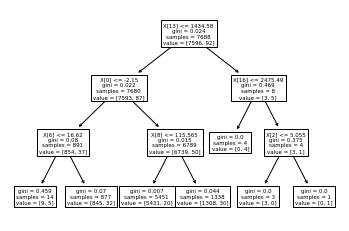

In [17]:
tree.plot_tree(clf)

In [18]:
from sklearn.tree import _tree

In [19]:
clf.tree_.feature

array([13,  0,  6, -2, -2,  8, -2, -2, 16, -2,  2, -2, -2], dtype=int64)

In [20]:
_tree.TREE_UNDEFINED

-2

非-2 的值代表該node使用那個feature進行分支<br>
-2代表這裡是leaf node

In [21]:
def get_rules(clf, feature_names, class_names):
    tree_ = clf.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [24]:
rules = get_rules(clf,data_new.iloc[:,2:20].columns, None)

In [25]:
rules

['if (A509 <= 1434.58) and (A104 > -2.15) and (A143 <= 115.565) then response: 5431.0 | based on 5,451 samples',
 'if (A509 <= 1434.58) and (A104 > -2.15) and (A143 > 115.565) then response: 1308.0 | based on 1,338 samples',
 'if (A509 <= 1434.58) and (A104 <= -2.15) and (A116 > 16.62) then response: 845.0 | based on 877 samples',
 'if (A509 <= 1434.58) and (A104 <= -2.15) and (A116 <= 16.62) then response: 9.0 | based on 14 samples',
 'if (A509 > 1434.58) and (A519 <= 2475.49) then response: 0.0 | based on 4 samples',
 'if (A509 > 1434.58) and (A519 > 2475.49) and (A106 <= 5.055) then response: 3.0 | based on 3 samples',
 'if (A509 > 1434.58) and (A519 > 2475.49) and (A106 > 5.055) then response: 0.0 | based on 1 samples']

In [26]:
for r in rules:
    print(r)

if (A509 <= 1434.58) and (A104 > -2.15) and (A143 <= 115.565) then response: 5431.0 | based on 5,451 samples
if (A509 <= 1434.58) and (A104 > -2.15) and (A143 > 115.565) then response: 1308.0 | based on 1,338 samples
if (A509 <= 1434.58) and (A104 <= -2.15) and (A116 > 16.62) then response: 845.0 | based on 877 samples
if (A509 <= 1434.58) and (A104 <= -2.15) and (A116 <= 16.62) then response: 9.0 | based on 14 samples
if (A509 > 1434.58) and (A519 <= 2475.49) then response: 0.0 | based on 4 samples
if (A509 > 1434.58) and (A519 > 2475.49) and (A106 <= 5.055) then response: 3.0 | based on 3 samples
if (A509 > 1434.58) and (A519 > 2475.49) and (A106 > 5.055) then response: 0.0 | based on 1 samples


In [44]:
clf.feature_importances_
#可以對應 clf.tree_.feature

array([0.12096878, 0.        , 0.09870471, 0.        , 0.        ,
       0.        , 0.18646706, 0.        , 0.04971875, 0.        ,
       0.        , 0.        , 0.        , 0.39608363, 0.        ,
       0.        , 0.14805707, 0.        ])

[計算方法](https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees)

In [28]:
y_pred = clf.predict(X_test)

In [31]:
acc = sum(y_pred == y_test)/len(y_test)

In [32]:
acc

0.987556904400607

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
confusion_matrix(y_test, y_pred)
#[y_test=0,y_pred=0,    y_test=0,y_pred=1
# y_test=1,y_pred=0,    y_test=1,y_pred=1]

#結果跟KNN 用ball-tree 且 k=2相同

array([[3254,    2],
       [  39,    0]], dtype=int64)

In [40]:
from sklearn.metrics import precision_score

In [41]:
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))
#micro 相當於算acc

Micro-averaged precision score: 0.99


In [42]:
macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))
# 算各自label的precision之後取算數平均

Macro-averaged precision score: 0.50


In [43]:
per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
#算各自label的precision
#3254/(3254+2) , 0/39+0

Per-class precision score: [0.99938575 0.        ]


# 分枝依據

有三種方法：

* Gini 不純度 (Gini impurity)
* entropy
* log_loss

假設資料為$(x_i,y_i),i=1,...,N$。 <br>
$x_i$表示特徵(feature)的值，$y_i$是第i個資料的label且$y_i\in\{1,...,K\}$<br>
以二分類問題來說，$K=2$

決策樹的第$m$個節點(node)裡面有$n_m$筆資料<br>
令

$Q_m = \{(x_i,y_i): x_i \space \text{in node} \space m\}$

則 $|Q_m| = n_m$.

令$p_m^k = \frac{1}{n_m}\sum\limits_{(x_i,y_i)\in Q_m}I_{\{y_i=k\}}$

則$p_m^k$ 表示 **節點$m$當中，label為$k$的比例**

gini 不純度： $\sum\limits_{k=1}^{K}p_m^k(1-p_m^k)$

entropy & log_loss: $-\sum\limits_{k=1}^{K}p_m^k\log p_m^k$

# 在每個節點用下列方法考慮分支：

在節點m分枝成左右各一個子節點，分支的方式為：

隨機選第$j$個特徵，設定門檻值$t_m$，小於等於門檻值就分枝到左子節點，大於則到右子節點。<br>
定義$\theta = (j,t_m)$，我們會在每次分枝的時候依照此參數找最佳分枝。<br>
我們稱左右子節點分別為 $Q_m^{left}$ 跟 $Q_m^{right}$，則

$Q_m^{left}(\theta) = \{(x_i,y_i) : (x_i,y_i) \in Q_m, \space \text{feature } j \text{ of } x_i \leq t_m \}$

$Q_m^{right}(\theta) = \{(x_i,y_i) : (x_i,y_i) \in Q_m, \space \text{feature } j \text{ of } x_i > t_m \}$

利用下列公式計算分枝的好壞程度

$f(Q_m,\theta) = \frac{n_m^{left}}{n_m} H(Q_m^{left}(\theta)) + \frac{n_m^{right}}{n_m} H(Q_m^{right}(\theta))$

其中函數 $H$ 可為Gini impurity，或是entropy<br>

透過調整$\theta$內的值讓$f(Q_m,\theta)$ 最小化之後，就依據此規則進行分枝

# 程式參數講解

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

1. criterion 為 不純度衡量方式，有三種選項："gini", "entropy", "log_loss"

但因為"entropy" = "log_loss"，所以實際上只有兩種選項。

2. 


splitter = "best" : 分枝會用重要性最高的feature去分枝

splitter = "random" : 分枝會隨機選feature去分枝

[splitter 之討論](https://stackoverflow.com/questions/46756606/what-does-splitter-attribute-in-sklearns-decisiontreeclassifier-do)

3. max_depth : 決策樹最大深度 避免overfitting或是展示圖片時再設定

4. min_samples_split : 節點當中必須有多少資料才會再做分枝 (i.e. 節點當中資料數量少於這個數值就不會再分枝)

5. min_samples_leaf : 節點當中必須包含多少資料數量

6. min_weight_fraction_leaf : 節點當中，樣本權重和之最小值。<br>
這個值限制了節點當中所有樣本權重和的最小值，如果小於這個值，則會和兄弟節點一起被剪枝。默認是0，就是不考慮權重問題，所有樣本的權重相同。


**此參數可於樣本不均衡時調整**(輸入type: float)

7. max_features : 分枝時最多考慮多少個feature當作依據
* 整數值: 分枝時最多考量此整數個feature
* 浮點數: 為比例值，分枝時最多考量這個比例的feature數量
* If “sqrt”, then max_features=sqrt(n_features).

* If “log2”, then max_features=log2(n_features).

* If None, then max_features=n_features.

8. random_state 如果沒設定，會讓每次重新訓練的結果不一樣 (預設是沒設定)

9. max_leaf_nodes : 最多幾個葉節點

10. min_impurity_decrease : 至少要讓不純度降低多少才會進行分枝。 0代表只要不純度有降就可以分枝。

11. class_weight : 調整這個會影響到$\frac{n_m^{left}}{n_m}$ 跟 $\frac{n_m^{right}}{n_m}$

在沒設定的情況下會直接去算上述之數值，但如果有設定class_weight則會取代掉。

[設定方式參考](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/#:~:text=The%20class_weight%20is%20a%20dictionary%20that%20defines%20each,0%20and%201%20can%20be%20defined%20as%20follows%3A)

可嘗試用grid search 方式調整class_weight去看結果如何

# 試試看調整class_weight

In [45]:
clf = DecisionTreeClassifier(random_state=42,class_weight = "balanced")

In [46]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

[Text(0.44419642857142855, 0.9864864864864865, 'X[13] <= 67.23\ngini = 0.5\nsamples = 7688\nvalue = [3844.0, 3844.0]'),
 Text(0.19553571428571428, 0.9594594594594594, 'X[12] <= -23.485\ngini = 0.419\nsamples = 5467\nvalue = [2752.438, 1169.913]'),
 Text(0.08, 0.9324324324324325, 'X[17] <= 39.505\ngini = 0.336\nsamples = 304\nvalue = [147.262, 543.174]'),
 Text(0.06857142857142857, 0.9054054054054054, 'gini = 0.0\nsamples = 37\nvalue = [18.724, 0.0]'),
 Text(0.09142857142857143, 0.9054054054054054, 'X[17] <= 1898.98\ngini = 0.309\nsamples = 267\nvalue = [128.538, 543.174]'),
 Text(0.08, 0.8783783783783784, 'X[16] <= 60.185\ngini = 0.28\nsamples = 230\nvalue = [109.814, 543.174]'),
 Text(0.06857142857142857, 0.8513513513513513, 'X[5] <= 5.98\ngini = 0.253\nsamples = 200\nvalue = [94.632, 543.174]'),
 Text(0.05714285714285714, 0.8243243243243243, 'X[8] <= 136.34\ngini = 0.231\nsamples = 178\nvalue = [83.499, 543.174]'),
 Text(0.045714285714285714, 0.7972972972972973, 'X[1] <= 4.465\ngini 

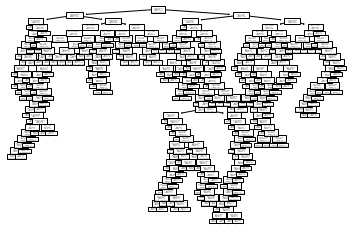

In [47]:
tree.plot_tree(clf)

In [48]:
rules = get_rules(clf,data_new.iloc[:,2:20].columns, None)

In [49]:
for r in rules:
    print(r)

if (A509 <= 67.23) and (A401 > -23.485) and (A401 <= 85.065) and (A143 <= 112.87) and (A51A <= 7085583.0) and (A144 > -8.39) and (A104 <= 33.8) and (A116 > 27.005) and (A115 > -18.55) then response: 2140.11 | based on 4,229 samples
if (A509 > 67.23) and (A104 > 1.725) and (A401 <= 34.855) and (A517 <= 4.085) and (A104 > 4.835) and (A105 > 0.45) then response: 266.185 | based on 526 samples
if (A509 <= 67.23) and (A401 > -23.485) and (A401 <= 85.065) and (A143 > 112.87) and (A143 > 128.565) then response: 155.359 | based on 307 samples
if (A509 > 67.23) and (A104 > 1.725) and (A401 <= 34.855) and (A517 > 4.085) and (A115 <= 3.105) then response: 83.499 | based on 165 samples
if (A509 <= 67.23) and (A401 > -23.485) and (A401 <= 85.065) and (A143 <= 112.87) and (A51A <= 7085583.0) and (A144 <= -8.39) and (A144 <= -9.065) then response: 72.872 | based on 144 samples
if (A509 <= 67.23) and (A401 > -23.485) and (A401 > 85.065) and (A145 > 5.06) and (A105 <= 49.02) and (A105 > -2.12) then res

In [50]:
clf.feature_importances_

array([0.08052343, 0.05930431, 0.00654893, 0.00656855, 0.04088959,
       0.03108777, 0.06109403, 0.03035263, 0.07211465, 0.0588137 ,
       0.01539762, 0.03091596, 0.208634  , 0.17775773, 0.00526918,
       0.04388926, 0.01489019, 0.05594846])

In [51]:
y_pred = clf.predict(X_test)

In [52]:
acc = sum(y_pred == y_test)/len(y_test)

In [53]:
acc

0.9772382397572079

In [54]:
confusion_matrix(y_test, y_pred)
#[y_test=0,y_pred=0,    y_test=0,y_pred=1
# y_test=1,y_pred=0,    y_test=1,y_pred=1]

array([[3218,   38],
       [  37,    2]], dtype=int64)

In [58]:
binary_precision = precision_score(y_pred, y_test, average='binary')
print('binary-averaged precision score: {0:0.2f}'.format(
      binary_precision))

binary-averaged precision score: 0.05


In [55]:
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

Micro-averaged precision score: 0.98


In [56]:
macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

Macro-averaged precision score: 0.52


In [57]:
per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

Per-class precision score: [0.98832924 0.05128205]
